In [96]:
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt

In [97]:
data_orig = np.genfromtxt('a2_data/housepricedata.csv',delimiter=',',skip_header=1)
print("Dataset : \n\n"+ str(data_orig))
print("\nDimensions of dataset : "+str(data_orig.shape))

Dataset : 

[[8.450e+03 7.000e+00 5.000e+00 ... 0.000e+00 5.480e+02 1.000e+00]
 [9.600e+03 6.000e+00 8.000e+00 ... 1.000e+00 4.600e+02 1.000e+00]
 [1.125e+04 7.000e+00 5.000e+00 ... 1.000e+00 6.080e+02 1.000e+00]
 ...
 [9.042e+03 7.000e+00 9.000e+00 ... 2.000e+00 2.520e+02 1.000e+00]
 [9.717e+03 5.000e+00 6.000e+00 ... 0.000e+00 2.400e+02 0.000e+00]
 [9.937e+03 5.000e+00 6.000e+00 ... 0.000e+00 2.760e+02 0.000e+00]]

Dimensions of dataset : (1460, 11)


In [98]:
#Extacting Y
y_orig = data_orig[:,-1]
print("Output Y   :"+str(y_orig))
print("Shape of Y : "+str(y_orig.shape))

Output Y   :[1. 1. 1. ... 1. 0. 0.]
Shape of Y : (1460,)


In [99]:
#Removing Rank 1 array
Y = np.reshape(y_orig,(y_orig.shape[0],1)).T    
print("Shape of Y: "+ str(Y.shape))
print((np.sum(Y)/1460)*100)

Shape of Y: (1, 1460)
49.86301369863014


In [100]:
#Extracting vectorized input feature X (transposed)
X = data_orig[:,0:-1].T
print(X.shape)

(10, 1460)


In [101]:
def standardize(x):
    x_mean = np.mean(x,axis=1, keepdims=True)
    x_std = np.std(x, axis=1, keepdims=True)+0.0000001

    X = (x - x_mean)/x_std   #Python Broadcasting

    return X

In [102]:
X = standardize(X)

In [103]:
#Splitting into Train, Test sets ( with a fixed seed )
train_split_percent = 80
test_split_percent = 20

train_X , test_X = X[:, : int( (train_split_percent/100)*X.shape[1])] , X[:,int( (train_split_percent/100)*X.shape[1]) : ]
train_Y , test_Y = Y[:, : int( (train_split_percent/100)*X.shape[1])] , Y[:,int( (train_split_percent/100)*X.shape[1]) : ]
print("\nShape of Training set X : "+str(train_X.shape))
print("Shape of Training set Y : "+str(train_Y.shape))
print("\nShape of Test set   X   : "+str(test_X.shape))
print("Shape of Test set Y     : "+str(test_Y.shape))


Shape of Training set X : (10, 1168)
Shape of Training set Y : (1, 1168)

Shape of Test set   X   : (10, 292)
Shape of Test set Y     : (1, 292)


In [104]:
m_train = train_X.shape[1]
m_test  = test_X.shape[1]
print("No of training examples : "+str(m_train))
print("No of test example      : "+str(m_test))
print((np.sum(1-test_Y)/292)*100)

No of training examples : 1168
No of test example      : 292
50.0


In [105]:
def sigmoid(Z):
    sigz= 1/(1+np.exp(-Z))
    sigz[sigz==1] = 0.99999999999             #Incase of flow
    sigz[sigz==0] = 0.000000000001
    return sigz        

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [106]:
def initialize_parameters_deep(layers):
    p = {}
    L = len(layers)            

    for l in range(1, L):
        p['W' + str(l)] = np.random.randn(layers[l],layers[l-1])*(2/layers[l-1])**0.5
        p['b' + str(l)] = np.zeros((layers[l],1))
        
    return p

In [107]:
def linear_forward(A, W, b):
   
    Z = np.dot(W,A)+b
    #Z = standardize(Z) Batch-Normalize with u,var=1
    cache = (A, W, b)
    
    return Z, cache

In [108]:
def linear_activation_forward(A_prev, W, b, activation,layer):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z), sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z), relu(Z)
        dropout_cache = A
        D = np.random.rand(A.shape[0],A.shape[1]) 
        if layer==1:
            D[:,:]=1
        else:
            D = (D < keep_prob).astype(int)                                         
            A = A*D                                         
            A = A/keep_prob 
        global Dcache 
        Dcache = D
    
    cache = (linear_cache, activation_cache,Dcache)

    return A, cache

In [109]:
def forwardprop(X, p):

    caches = []
    D = []
    A = X
    L = len(p) // 2                
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, p["W"+str(l)], p["b"+str(l)],"relu",l)
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, p["W"+str(L)], p["b"+str(L)],"sigmoid",l)
    caches.append(cache)
            
    return AL, caches

In [110]:
def compute_cost(AL, Y,p):
    
    m = Y.shape[1]
    #print(AL)
    cost = (-1/m)*(np.sum(Y*np.log(AL)+(1-Y)*np.log(1-AL)))
    sumW = 0
    L = len(p) // 2 
    for l in range(1, L):
        sumW= sumW + np.sum(np.square(p["W"+str(l)]))
        
    L2_cost= lambd*(sumW)/(2*m)
    cost = cost + L2_cost
    cost = np.squeeze(cost)     
   
    return cost

In [111]:
def linear_backward(dZ, linear_cache,keep_prob):
    
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ,A_prev.T)
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [112]:
def linear_activation_backward(dA, cache, activation,keep_prob):

    linear_cache, activation_cache, dropout_cache = cache
    global dA_prev, dW, db
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache,keep_prob)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache,keep_prob=1)
    
    return dA_prev, dW, db

In [113]:
def backwardprop(AL, Y, caches):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    #print(caches[-2][-1].shape)
    #print(L)
    
    current_cache = caches[-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache,"sigmoid",keep_prob=1)
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        global Dprev_cache
        D_prev = caches[l-1][2]
        global dA_prev_temp, dW_temp, db_temp
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache,
                                                                "relu",keep_prob)
        if l > 0:
            dA_prev_temp = np.multiply(dA_prev_temp,D_prev)
            dA_prev_temp = dA_prev_temp/keep_prob
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [114]:
def initialize_adam(p) :

    L = len(p) // 2 
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((p["W" + str(l+1)].shape[0],p["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((p["b" + str(l+1)].shape[0],p["b" + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((p["W" + str(l+1)].shape[0],p["W" + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((p["b" + str(l+1)].shape[0],p["b" + str(l+1)].shape[1]))
   
    return v, s

In [115]:
def Adam_optimizer(p, g, v, s, t,m, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8,):

    L = len(p) // 2                 
    v_corrected = {}                         
    s_corrected = {}                        
    
    # Perform Adam update on all parameters
    for l in range(L):
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)]+(1-beta1)*g['dW'+str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)]+(1-beta1)*g['db'+str(l+1)]
       
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1-pow(beta1,t)) 
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1-pow(beta1,t))
        
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)]+(1-beta2)*np.power(g['dW'+str(l+1)],2)
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)]+(1-beta2)*np.power(g['db'+str(l+1)],2)

        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-pow(beta2,t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-pow(beta2,t))

        p["W" + str(l+1)] = p["W" + str(l+1)]-learning_rate*np.divide(v_corrected["dW" + str(l+1)],np.sqrt(s_corrected["dW" + str(l+1)])+epsilon)
        p["W" + str(l+1)] = p["W"+ str(l+1)] +(lambd/m)*p["W" + str(l+1)]
        p["b" + str(l+1)] = p["b" + str(l+1)]-learning_rate*np.divide(v_corrected["db" + str(l+1)],np.sqrt(s_corrected["db" + str(l+1)])+epsilon)

    return p, v, s

In [116]:
def model(X, Y, layers_dims, learning_rate0 = 0.003, epocs = 3000,
                  beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, print_after=1):

    costs = []                      
    
    parameters = initialize_parameters_deep(layers_dims)
    v, s = initialize_adam(parameters)
    
    t = 0
    m=X.shape[1]
    
    for i in range(0, epocs):
        AL, caches = forwardprop(X, parameters)
        cost = compute_cost(AL, Y,parameters)
        grads = backwardprop(AL, Y, caches)
        
        t = t + 1
        learning_rate = learning_rate0/(1+decay_rate*i)
        
        parameters, v, s = Adam_optimizer(parameters, grads, v, s,
                                                               t,m, learning_rate, beta1, beta2,  epsilon,)
        if i % print_after == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if  i % print_after == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per '+str(print_after)+')')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [117]:
def evaluate(Y,Yhat,Set):
    spos=0
    
    for i in range(Y.shape[1]): 
        if Y[0,i]==1 and Yhat[0,i]==1:
            spos = spos+1
            
    p = spos /np.sum(Yhat == 1)
    r = spos/ np.sum( Y == 1)
    acc = np.mean(Y == Yhat)
    f1score = 2*p*r/(p+r)
    
    #print(Set+" :       "+str(p) + "  "+str(r)+"  "+str(f1score)+"  "+str(acc))
    data = [{'Precision': p, 'Recall': r, 'Accuracy': acc,'F-score': f1score}] 
    df = pd.DataFrame(data)
    
    display(df)
    error = (1-acc)*100
    print(Set+" :       "+'%0.3f'%error+" %" +'\t'+str(f1score))
    
    return

Cost after iteration 0: 0.722761
Cost after iteration 100: 0.629324
Cost after iteration 200: 0.509269
Cost after iteration 300: 0.404124
Cost after iteration 400: 0.322703
Cost after iteration 500: 0.269336
Cost after iteration 600: 0.244067
Cost after iteration 700: 0.231895
Cost after iteration 800: 0.228874
Cost after iteration 900: 0.228984


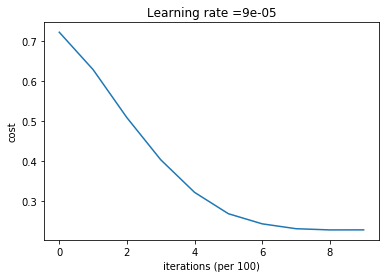

,Precision,Recall,Accuracy,F-score
0,0.92517,0.931507,0.928082,0.928328


Test  :       7.192 %	0.9283276450511946
Seed of initialization : 3


In [118]:
global dropout_cache
global keep_prob
global lambd

np.random.seed(3)
keep_prob=1
lambd = 5e-2
decay_rate=0

p = model(train_X, train_Y, layers_dims = [10,64,32,16,8,4,1], epocs =901, 
                           learning_rate0 = 0.00009,  beta1 = 0.9, beta2 = 0.9,  epsilon = 1e-8, 
                           print_after = 100)
keep_prob=1

def predict(X,p):
    AL = forwardprop(X, p)[0]
    Y_prediction = AL
    for i in range(AL.shape[1]):
          Y_prediction[0, i] = 1 if AL[0, i] > 0.5 else 0
   
    return Y_prediction 

test_Yhat = predict(test_X,p)
train_Yhat = predict(train_X,p)

#evaluate(train_Y,train_Yhat,"Train ")
evaluate(test_Y,test_Yhat,"Test ")

print("Seed of initialization : "+str(3))